# Разведочный анализ
## Щека Дмитрий, 24.М41

В качестве данных для анализа был взят набор, содержащий данные мностров настольной ролевой игры DnD 5-ой редакции. Скачать его можно тут: https://www.kaggle.com/datasets/mrpantherson/dnd-5e-monsters

### Описание датасета:
- **name** --- имя существа
- **cr** --- challange rating (целевой признак). Сложность столкновения с существом
- **type** --- тип существа (животное, дракон...)
- **ac** --- armor class (класс доспеха), как тяжело попасть по существу
- **hp** --- health points (очки здоровья)
- **align** --- говорит о стандартном поведении существа
- **legendary** --- является ли существо легендарным
- **source** --- из какой книги взято существо
- **str, dex, con, int, wis, cha** --- характеристики существа: сила, ловкость, телосложение, интеллект, мудрость, харизма

Предсказывать будем признак рейтинга опасности (**cr**). Это важная задача, потому что в первую очередь создаются остальные характеристики существа, а сам рейтинг опасности дается навскидку, поэтому автоматическая система могла бы очень облегчить такую задачу

Из поставленных задач мне кажется, что я выполнил все, поэтому хотелось бы 10 баллов :3

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dnd_monsters.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       762 non-null    object 
 1   url        401 non-null    object 
 2   cr         761 non-null    object 
 3   type       762 non-null    object 
 4   size       762 non-null    object 
 5   ac         762 non-null    int64  
 6   hp         762 non-null    int64  
 7   speed      248 non-null    object 
 8   align      762 non-null    object 
 9   legendary  43 non-null     object 
 10  source     762 non-null    object 
 11  str        401 non-null    float64
 12  dex        401 non-null    float64
 13  con        401 non-null    float64
 14  int        401 non-null    float64
 15  wis        401 non-null    float64
 16  cha        401 non-null    float64
dtypes: float64(6), int64(2), object(9)
memory usage: 101.3+ KB


In [3]:
df.head()

,name,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,https://www.aidedd.org/dnd/monstres.php?vo=aar...,1/4,humanoid (aarakocra),Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0
1,abjurer,NaN,9,humanoid (any race),Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,NaN,NaN,NaN,NaN,NaN,NaN
2,aboleth,https://www.aidedd.org/dnd/monstres.php?vo=abo...,10,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0
3,abominable-yeti,NaN,9,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,NaN,NaN,NaN,NaN,NaN,NaN
4,acererak,NaN,23,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка
Перед анализом проведу немного модификаций датасета, чтобы с ним было удобнее работать

Хотелось бы рассматривать целевой признак **cr** как значения типа float, поэтому заменим значения вроде 1/4

In [4]:
df["cr"] = df["cr"].apply(lambda x: float(x[0]) / float(x[2]) if '/' in str(x) else x)
df["cr"] = df["cr"].astype(float)

Хотелось бы использовать тип существа, однако их слишком много. Можно попробовать объединить значения, которые имеют общий тип, но имеют различные уточнения, например: humanoid (aarakocra) и humanoid (any race)

In [5]:
df["type"] = df["type"].astype(str)
df["type"] = df["type"].apply(lambda x: x.split()[0] if ' ' in x else x)

Также уберу колонку с ссылкой на дополнительную информацию, потому что ей все равно никак не буду пользоваться

In [6]:
df = df.drop("url", axis=1)
df.head()

,name,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,0.25,humanoid,Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0
1,abjurer,9.00,humanoid,Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,NaN,NaN,NaN,NaN,NaN,NaN
2,aboleth,10.00,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0
3,abominable-yeti,9.00,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,NaN,NaN,NaN,NaN,NaN,NaN
4,acererak,23.00,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df["align"].value_counts()

unaligned                   171
chaotic evil                151
lawful evil                 113
neutral evil                110
any alignment                62
neutral                      43
chaotic neutral              26
lawful good                  23
lawful neutral               22
chaotic good                 17
neutral good                  8
any non-good alignment        5
any evil alignment            4
any non-lawful alignment      3
any chaotic alignment         2
neutral good                  1
chaotic good                  1
Name: align, dtype: int64

В признаке **align** слишком много вариантов. Хотелось бы убрать малочисленные, добавив их в какую-то более обширную категорию

In [8]:
def Merge(x):
    if ("any" in x):
        return "any"
    # Там еще есть пару значений, которые почему-то не в своей группе
    if ("neutral good" in x):
        return "neutral good"
    if ("chaotic good" in x):
        return "chaotic good"
    return x

df["align"] = df["align"].astype(str)
df["align"] = df["align"].apply(Merge)

# Первичный анализ признаков

## Категориальный признак type

In [9]:
df["type"].value_counts()

humanoid       189
beast          106
fiend           89
monstrosity     86
undead          50
dragon          47
elemental       38
aberration      37
giant           27
construct       24
plant           24
fey             21
ooze             8
celestial        8
swarm            8
Name: type, dtype: int64

In [10]:
df.groupby("type").aggregate({'cr':'mean'}).sort_values(by="cr")

,cr
type,
beast,1.038915
swarm,1.218750
plant,2.119792
ooze,3.343750
humanoid,3.653439
fey,3.803571
monstrosity,5.207353
aberration,6.273649
construct,6.713542


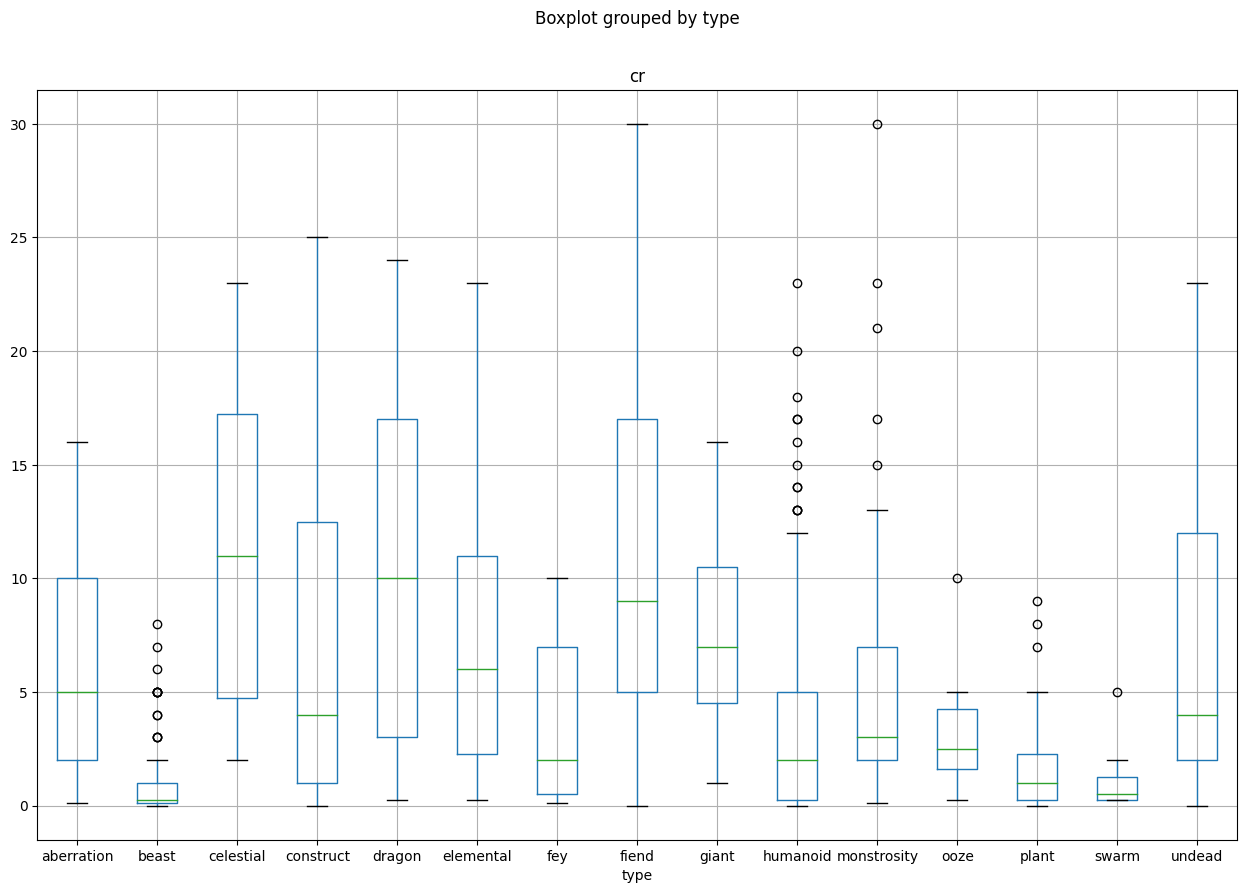

In [11]:
df.boxplot(column="cr", by="type", figsize=(15, 10));

Некоторые типы существ имеют достаточно небольшой разброс в **cr**, поэтому могут стать хорошей опорой для нахождения целевого признака

## Категориальный признак align 

In [12]:
df["align"].value_counts()

unaligned          171
chaotic evil       151
lawful evil        113
neutral evil       110
any                 76
neutral             43
chaotic neutral     26
lawful good         23
lawful neutral      22
chaotic good        18
neutral good         9
Name: align, dtype: int64

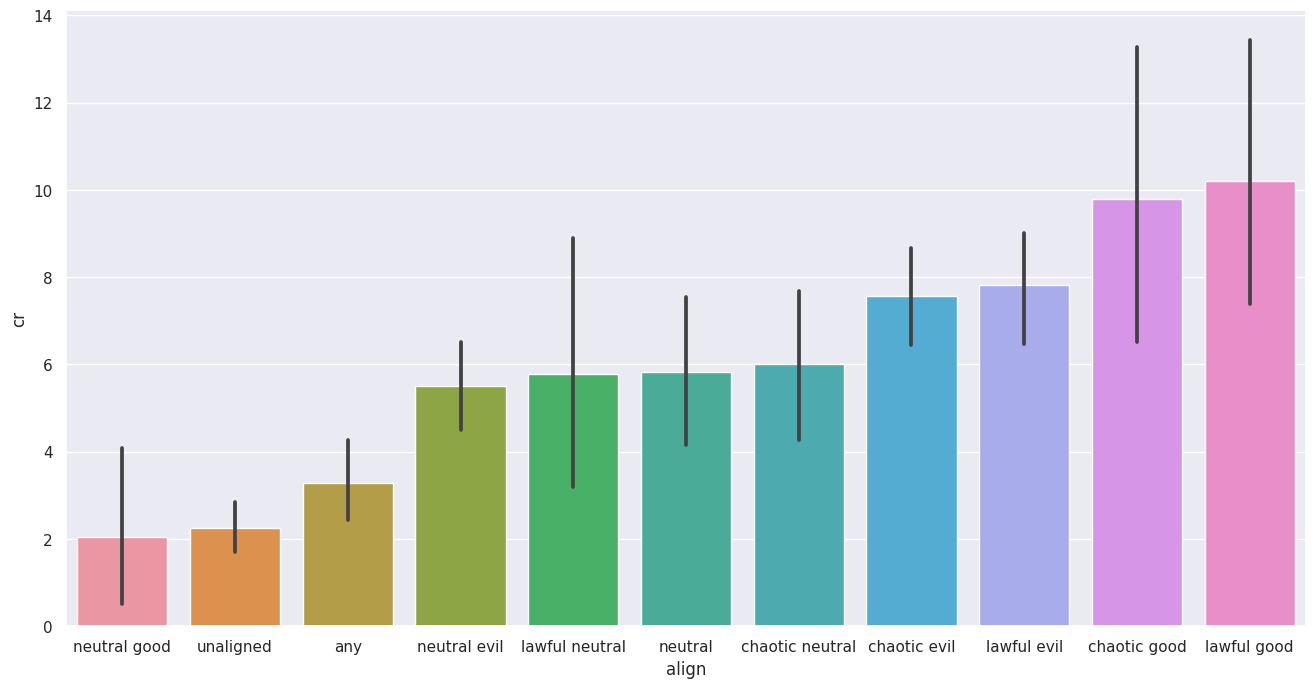

In [13]:
sns.set_theme(rc={'figure.figsize':(16,8)})
order = df.groupby("align").agg("mean").sort_values(by="cr").index.values.tolist()
sns.barplot(x = "align", y = "cr", data = df, order=order);

Довольно неожиданный результат, что хорошие существа оказались наиболее опасными. Если предположить, то это может быть связано с тем, что игры в DnD обычно проводятся в рамках морали, хотя некоторым игрокам очень хочется почудить. Поэтому в качестве дополнительного сдерживающего фактора добрым персонажам дают большую силу (чтобы игроки боялись, а мастер не потерял важного персонажа, которого долго создавал, если игроки все-таки решатся на него напасть)

Unaligned мировоззрение обычно имеют существа без интеллекта, обычно какие-то дикие животные, а мы уже знаем, что животные имеют невысокий рейтинг опасности.

In [14]:
pd.crosstab(df['type'], df['align'], margins=True).\
        style.background_gradient()

align,any,chaotic evil,chaotic good,chaotic neutral,lawful evil,lawful good,lawful neutral,neutral,neutral evil,neutral good,unaligned,All
type,,,,,,,,,,,,
aberration,0,9,0,6,11,1,1,2,7,0,0,37
beast,0,0,0,0,1,0,0,1,1,1,102,106
celestial,0,0,2,0,0,6,0,0,0,0,0,8
construct,0,1,0,0,5,0,6,3,0,0,9,24
dragon,0,13,9,0,8,12,0,1,0,1,3,47
elemental,0,2,1,2,1,0,1,16,13,0,2,38
fey,0,5,0,9,0,1,0,1,3,2,0,21
fiend,1,44,0,0,30,0,0,0,14,0,0,89
giant,1,15,2,3,3,0,0,1,1,1,0,27


Среди хороших оказались преимущественно драконы и божественные сущности, поэтому логично, что среди них высокий рейтинг опасности. Но если не учитывать их, то хаотично и законно-злые персонажи демонстрируют высокий уровень опасности (как можно видеть из таблицы, вероятно из-за демонов (**fiend**))

## Количественный признак hp

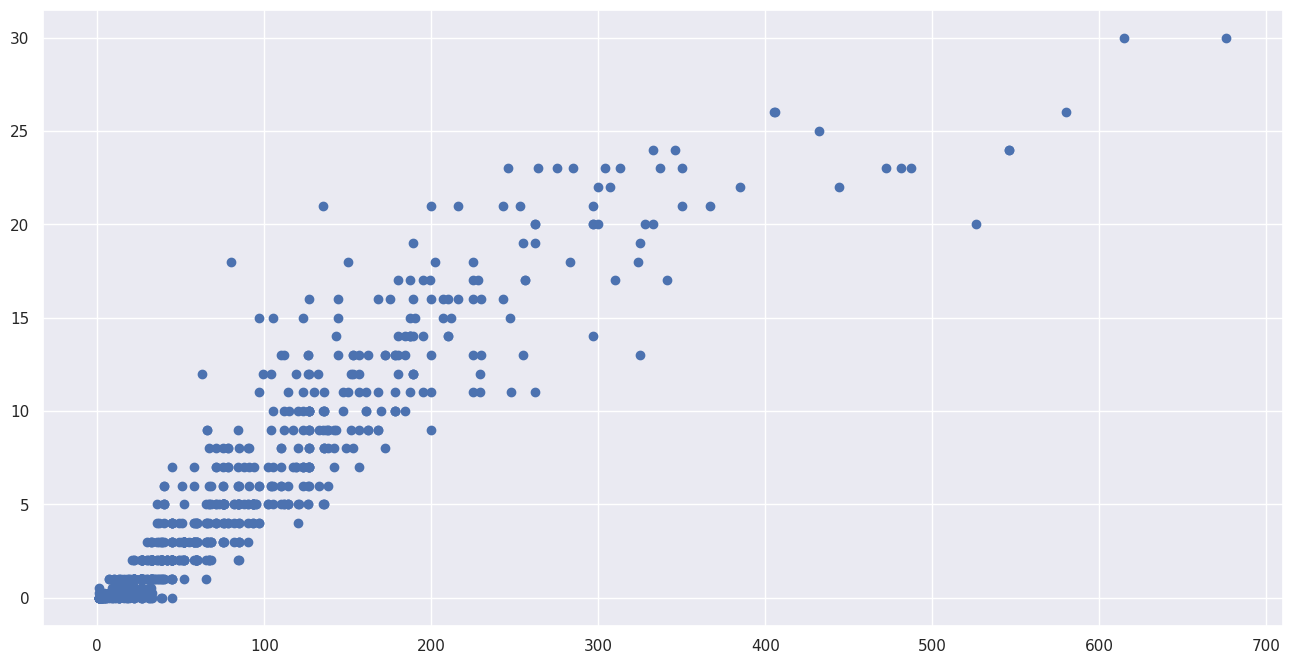

In [15]:
plt.scatter(df["hp"], df["cr"]);

Видна прямая зависимость целевого признака от количества очков здоровья, тут в принципе очевидно 

## Дискретный признак ac

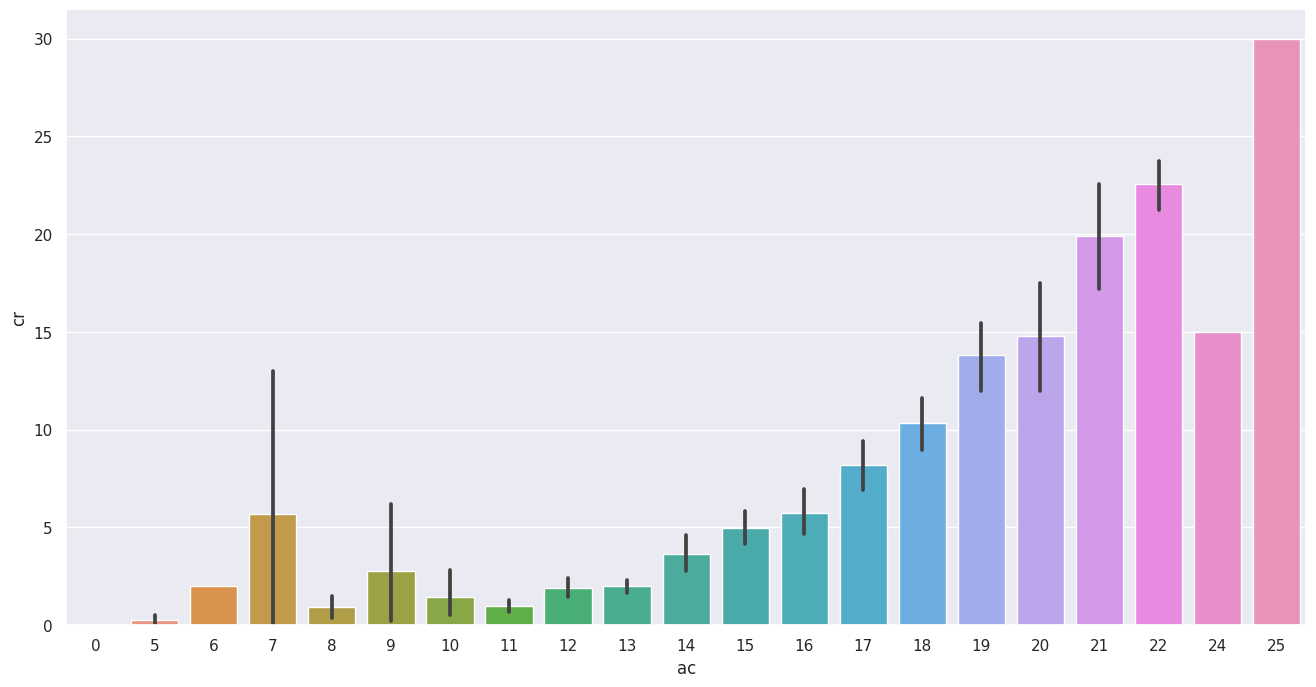

In [16]:
sns.barplot(x='ac', y='cr', data=df);

Тут тоже все достаточно просто, потому что видно линейную зависимость

## Порядковый признак size
Мне кажется есть смысл назвать его порядковым (?)

In [17]:
df["size"].value_counts()

Medium        381
Large         195
Huge           69
Small          54
Tiny           38
Gargantuan     25
Name: size, dtype: int64

In [18]:
sizes = ["Tiny", "Small", "Medium", "Large", "Huge", "Gargantuan"]
df["size"] = pd.Categorical(df["size"], 
                      categories=sizes,
                      ordered=True)

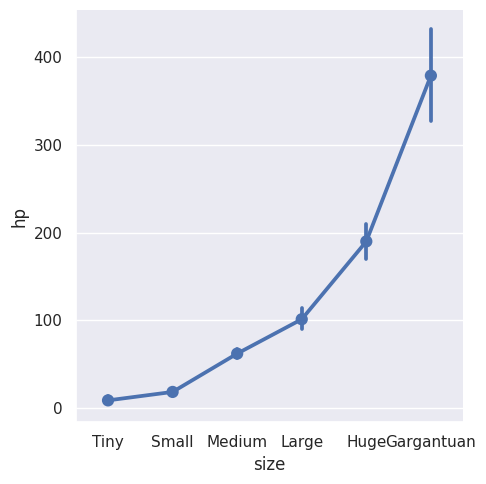

In [19]:
sns.catplot(x='size', y='hp', data=df, kind="point")

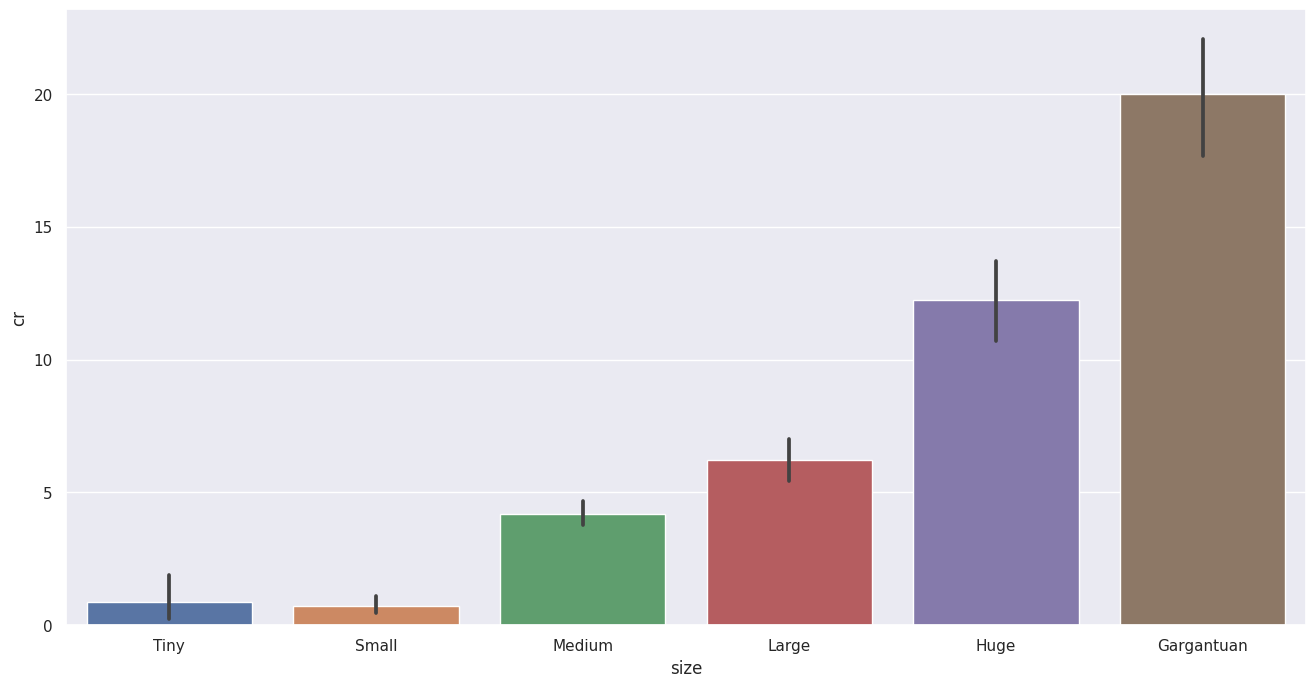

In [20]:
sns.barplot(x='size', y='cr', data=df);

Учитывая очевидную зависимость между размером и количеством здоровья, а также что рейтинг опасности линейно зависит от здоровья, то понятно, что и тут прямая зависимость

## Категориальный признак legendary

In [21]:
pd.crosstab(df['legendary'], df['type'], margins=True).\
        style.background_gradient()

type,aberration,celestial,dragon,fiend,humanoid,monstrosity,undead,All
legendary,,,,,,,,
Legendary,3,4,20,4,1,5,6,43
All,3,4,20,4,1,5,6,43


Большинство легендарных существ --- это драконы, поэтому понятно, что они в среднем имеют более высокий рейтинг опасности

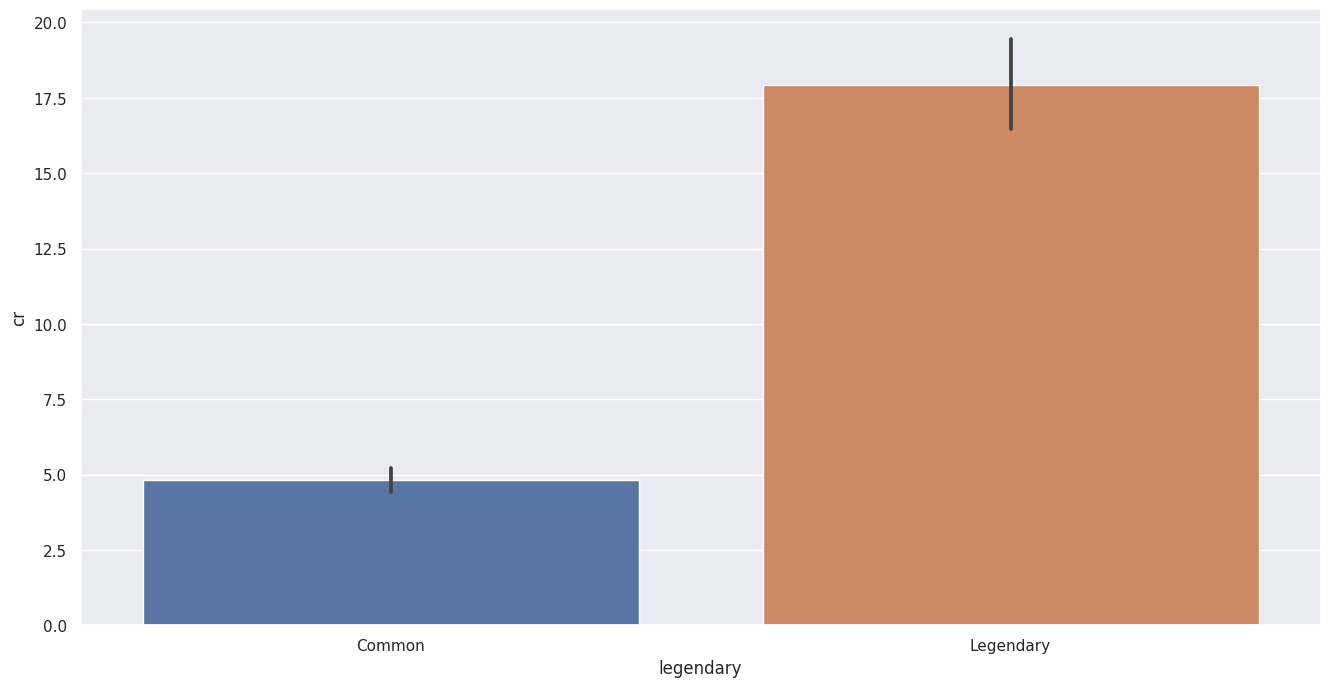

In [22]:
df["legendary"] = df["legendary"].fillna("Common")
sns.barplot(x = "legendary", y = "cr", data = df);

## Количественные признаки str, agi, int, con, wis, cha
В этих колонках мы имеем довольно много пропущенных значений, поэтому придется их заполнить. 

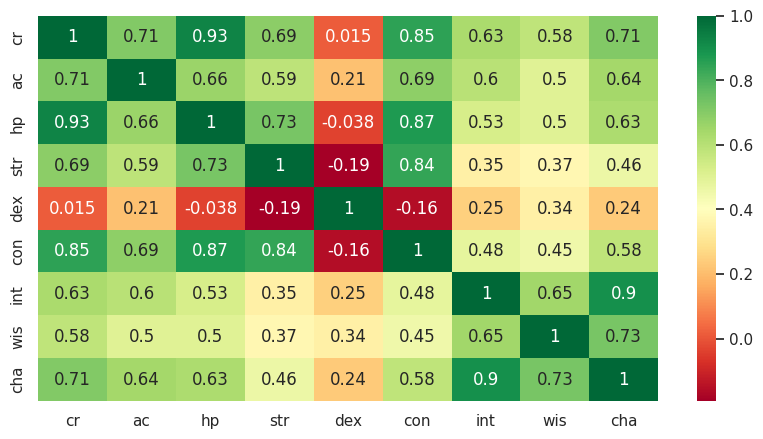

In [23]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Тут есть интересные зависимости между этими признаками:
- Интеллект и харизма имеют высокую корреляцию. Это логично, ведь существа с низким интеллектом в принципе вряд ли могут разговаривать, соответственно и проявлять какую-то харизму
- Есть зависимость между силой и телосложением, что тоже имеет смысл
- Зависимость между телосложением и очками здоровья тоже ожидаема, потому что по правилам игры телосложение добавляет очки здоровья

In [24]:
def FillNan(x):
    if (not np.isnan(x[stat])):
        return x
    feats = ["size", "cr", "type", "align"]
    mean = 0.0
    cnt = 0
    for feat in feats:
        temp = df[df[feat] == x[feat]][stat].agg("mean")
        if (not np.isnan(temp)):
            cnt += 1
            mean += temp 
    x[stat] = round(mean / cnt)
    return x

stats = list(df.columns.values)[10:]
for stat in stats:
    df = df.apply(FillNan, axis=1)
df

## Выводы
- **type:** Типы животных, растений и роя имеют небольшой разброс в значении рейтинга опасности, по ним достаточно точно его можно предсказать
- **size, hp:** эти два признака имеют линейную зависимость с рейтингом опасности
- **align:** тут оказалось, что почти все добрые (но не нейтрально, а с акцентуацией) имеют очень высокий рейтинг опасности. За ними следуют уже злые и нейтральные
- **legendary:** легендарные существа оказались более чем в 3 раза более опасными, чем обычные

# Feature Engineering and Data Cleaning

Уже было сделано несколько преобразований до этого: 
- Убран столбец **url**
- Значения **cr** преобразованы во float (некоторые значения вроде "1/4" мешали этому)
- Объединены некоторые значения **align**
- Заполнены пропущенные значения для всех характеристик


## Новый признак  категории очков здоровья hp_category 


In [28]:
df['hp_category'] = pd.qcut(df['hp'], 8)
df.groupby(['hp_category'])['cr'].mean().to_frame().style.background_gradient(cmap='summer_r')

,cr
hp_category,
"(-0.001, 13.0]",0.197198
"(13.0, 22.0]",0.532353
"(22.0, 37.0]",1.405172
"(37.0, 58.0]",2.697917
"(58.0, 84.0]",4.593750
"(84.0, 126.0]",6.978723
"(126.0, 184.0]",10.402174
"(184.0, 676.0]",18.126316


In [29]:
df['hp_category'] = 0
df.loc[df['hp'] <= 13, 'hp_category'] = 0
df.loc[(df['hp'] > 13) & (df['hp'] <= 22), 'hp_category'] = 1
df.loc[(df['hp'] > 22) & (df['hp'] <= 37), 'hp_category'] = 2
df.loc[(df['hp'] > 37) & (df['hp'] <= 58), 'hp_category'] = 3
df.loc[(df['hp'] > 58) & (df['hp'] <= 84), 'hp_category'] = 4
df.loc[(df['hp'] > 84) & (df['hp'] <= 126), 'hp_category'] = 5
df.loc[(df['hp'] > 126) & (df['hp'] <= 184), 'hp_category'] = 6
df.loc[(df['hp'] > 184) & (df['hp'] <= 676), 'hp_category'] = 7

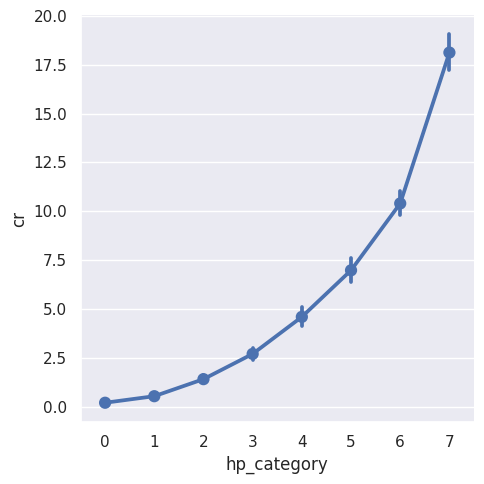

In [34]:
sns.catplot(x='hp_category', y='cr', data=df, kind="point");

## Трансформация строк в числа
Подготавливаем данные, приводим к удобному для обучению формату.

In [53]:
df['size'].replace(["Tiny", "Small", "Medium", "Large", "Huge", "Gargantuan"], list(range(6)), inplace=True)
types = list(df.groupby("type").aggregate({'cr':'mean'}).sort_values(by="cr").index)
df["type"].replace(types, list(range(len(types))), inplace=True)
aligns = list(df.groupby("align").aggregate({'cr':'mean'}).sort_values(by="cr").index)
df["align"].replace(aligns, list(range(len(aligns))), inplace=True)
df["legendary"].replace(["Common", "Legendary"], [0, 1], inplace=True)

,name,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha,hp_category
0,aarakocra,0.25,4,2,12,13,fly,0,0,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0,0
1,abjurer,9.00,4,2,12,84,NaN,2,0,Volo's Guide to Monsters,15.0,13.0,15.0,11.0,12.0,12.0,4
2,aboleth,10.00,7,3,17,135,swim,8,1,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0,6
3,abominable-yeti,9.00,6,4,15,137,NaN,7,0,Monster Manual,20.0,12.0,18.0,10.0,13.0,12.0,6
4,acererak,23.00,9,2,21,285,NaN,3,0,Adventures (Tomb of Annihilation),17.0,13.0,17.0,12.0,13.0,13.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,yuan-ti-pureblood,1.00,4,2,11,40,NaN,3,0,Monster Manual (BR),11.0,12.0,11.0,13.0,12.0,14.0,3
758,zaratan,22.00,11,5,21,307,swim,5,0,Mordenkainen's Tome of Foes,21.0,12.0,21.0,13.0,14.0,14.0,7
759,zariel,26.00,13,3,21,580,fly,8,1,Mordenkainen's Tome of Foes,27.0,24.0,28.0,26.0,27.0,30.0,7
760,zombie,0.25,9,2,8,22,NaN,3,0,Monster Manual (SRD),13.0,6.0,16.0,3.0,6.0,5.0,1


## Удаление ненужных признаков

**name, source, speed** --- неважно

**hp** --- его мы заменили на категориальный

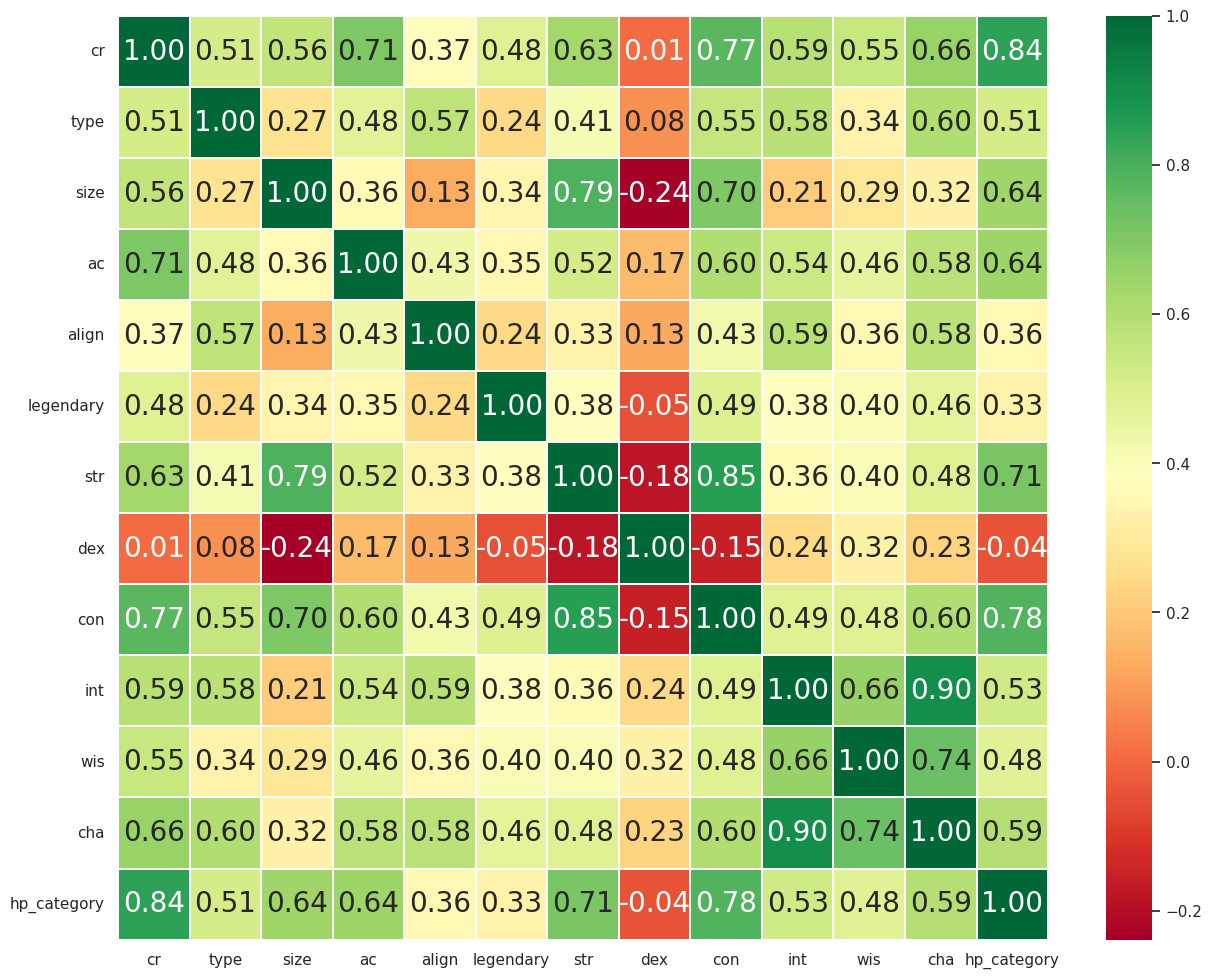

In [60]:
df.drop(["name", "source", "speed", "hp"], axis=1, inplace=True)
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20}, fmt=".2f")
fig = plt.gcf()
fig.set_size_inches(15, 12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()